In [1]:
import numpy as np
import xraylib as xrl
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

import fresnel

In [2]:
%matplotlib inline

In [3]:
# photon energy 
energy = 12.5 # keV
wavelength = 1.2398 / (energy * 1e3) * 1e-3 # mm

# material parameters
density_Ge = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Ge'))
density_Polyimide = 1.42
density_Si = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Si'))
n_Ge = xrl.Refractive_Index('Ge', energy, density_Ge)
n_Si = xrl.Refractive_Index('Si', energy, density_Si)
n_PI = xrl.Refractive_Index('Kapton Polyimide Film', energy, density_Polyimide)

# geometry and discretization
wg_radius = 24e-6
xtot = 100e-6 # mm
ztot = 0.4 # mm
nx = 1000
nz = 1600

# define waveguide
n_clad = n_Si
n_core = 1

# calculate refractive index
xx = np.linspace(-xtot/2, xtot/2, nx)
zz = np.linspace(0, ztot, nz, endpoint=False)
core = (np.abs(xx) < wg_radius)
cladding = ~core

refractive_index = n_clad * cladding + n_core * core

# units
dx = xtot / nx / wavelength
dz = ztot / nz / wavelength
print(f"dx: {dx}, dz: {dz} wavelengths")

# initial value (incoming field)
u0 = np.exp(- 1 * xx ** 2 / wg_radius**2) * np.exp(1j * xx * 2 * np.pi / wavelength * np.sin(5e-4))

dx: 1.0082271334086144, dz: 2520.5678335215357 wavelengths


In [4]:
# boundary conditions
# use exact solution (of paraxial Helmholtz equation) for homogeneous object
k0 = 2 * np.pi
zz_ul = zz / wavelength # unitless
boundary_layer = 0 * np.exp(1j * k0 / 2 * (n_clad**2 - 1) * zz_ul)

In [5]:
wavelength

9.918400000000001e-08

## finite-difference method without PML

In [6]:
propagator = fresnel.FDPropagator2d(refractive_index, u0, dz, dx)

In [7]:
field = np.zeros((nz, nx), dtype=np.complex128)

field[0,...] = u0

for iz in tqdm(range(1, nz)):
    boundary = boundary_layer[iz]
    #boundary = 0j
    field[iz, ...] = propagator.step(refractive_index, (boundary, boundary))


100%|██████████| 1599/1599 [00:00<00:00, 9935.47it/s]


In [8]:
result = field.transpose()

fig, ax = plt.subplots(dpi=150)

im = ax.imshow(np.abs(result[:,:])**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6])
#im.set_clim(0, 1)
fig.colorbar(im)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (nm)')

Text(0, 0.5, '$x$ (nm)')

Text(0, 0.5, '$x$ (nm)')

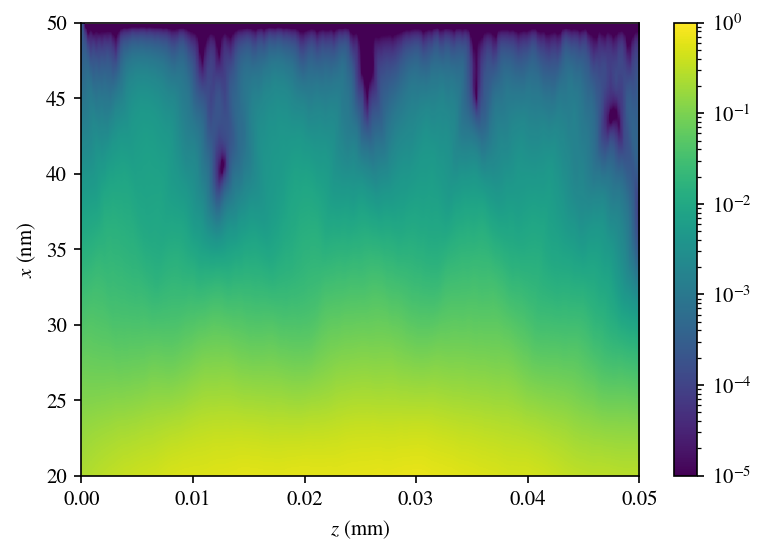

In [9]:
result = field.transpose()

fig, ax = plt.subplots(dpi=150)

im = ax.imshow(np.abs(result[:,:])**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6],norm=colors.LogNorm(vmin=1e-5, vmax=1))
ax.set_xlim(0, 0.05)
ax.set_ylim(20, 50)
fig.colorbar(im)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (nm)')

## finite difference with PML

In [14]:
pml_width = int(10e-6 / wavelength / dx)
print(pml_width)
propagator = fresnel.FDPropagator2d(refractive_index, u0, dz, dx, pml_width, sigma_max=1)

99


In [15]:

field = np.zeros((nz, nx), dtype=np.complex128)

field[0,...] = u0

for iz in tqdm(range(1, nz)):
    #boundary = (0,0 )
    boundary = boundary_layer[iz]
    field[iz, ...] = propagator.step(refractive_index, (boundary, boundary))

100%|██████████| 1599/1599 [00:00<00:00, 10027.24it/s]


In [16]:
result = field.transpose()

fig, ax = plt.subplots(dpi=150)

im = ax.imshow(np.abs(result[:,:])**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6])
fig.colorbar(im)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (nm)')

Text(0, 0.5, '$x$ (nm)')

In [17]:
result = field.transpose()

fig, ax = plt.subplots(dpi=150)

im = ax.imshow(np.abs(result[:,:])**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6], norm=colors.LogNorm(vmin=1e-5, vmax=1))
ax.set_xlim(0, 0.05)
ax.set_ylim(20, 50)
fig.colorbar(im)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (nm)')

Text(0, 0.5, '$x$ (nm)')